In [ ]:
!pip install unidecode==1.2.0
!pip install wordcloud==1.8.1
!pip install gensim
!pip install pyLDAvis==3.3.1
!pip install pyLDAvis.gensim

In [ ]:
# numerical computation
import numpy as np

# data processing/manipulation
import pandas as pd
pd.options.mode.chained_assignment = None
import re
from unidecode import unidecode 
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
from collections import Counter
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
%matplotlib inline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
import seaborn as sns

# stopwords, tokenizer, stemmer
import nltk  
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# spell correction, lemmatization
from textblob import TextBlob
from textblob import Word

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary 
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.parsing.preprocessing import remove_stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# spacy for lemmatization and additional stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# LDA plotting tools
import pyLDAvis
import pyLDAvis.sklearn

import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
/root/venv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
2021-08-29 08:42:27.817221: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-29 08:42:27.817260: I tensorfl

In [ ]:
# Loading each dataset
pisa_df = pd.read_csv('pisa_df_unique.csv', lineterminator='\n')

In [ ]:
col_drops = ['Unnamed: 0', 'referenced_tweets', 'public_metrics', 'created_at',
       'entities', 'conversation_id',  
       'context_annotations', 'attachments', 'in_reply_to_user_id', 'username',
       'name', 'description', 'public_metrics_user', 'location', 'verified',
       'created_at_user', 'keyword', 'geo\r']

pisa_df = pisa_df.drop(columns=col_drops)

In [ ]:
pisa_df.rename(columns={"text": "tweet"}, inplace = True)
pisa_df.columns

Index(['lang', 'id', 'author_id', 'tweet'], dtype='object')

In [ ]:
#let's see how many tweets conain unique text
#but we don't remove the duplicates, since even if they are retweets, they still represent the voice of the rewteeter
print(pisa_df.shape)
print(f'Unique tweets: {pisa_df.tweet.nunique()}')

(151934, 4)
Unique tweets: 54306


## Preprocessing

In [ ]:
psa_df_backup = pisa_df.copy(deep = True)

pisa_df = pisa_df[pisa_df.lang == 'en']

pisa_df.shape

(80839, 4)

In [ ]:
keywords = ['pisa4development', 'pisaoecd', 'oecdpisa', 'pisa2003', 'pisa2006', 'pisa2009', 'pisa2012', 'pisa2015', 'pisa2018']

In [ ]:
'''
Helper function that:
    - removes accents
    - removes stopwords
    - removes punctuation
    - remove all 1 and 2 letter 'words' that we create after automatic removal of the apostrophe character
'''

def clean_text(text):
    
    # remove accents of text
    text=unidecode(text)
    
    # lowercase
    text=text.lower()
    
    text=re.sub(r'&amp;',' ',text) # remove ampersand 
    #text=re.sub(r'[^\sa-zA-Z0-9@\[\]]',' ',text) # remove characters: punctuation and other special characters, except for: alphabet letters, numbers, '@' and '\' 
    
    text=re.sub(r'@[A-Za-z0-9]+','',text) #remove mentions of other twitter accounts (remove the whole user name)
    text=re.sub(r'#','',text) # remove the hashtag symbol (but leaves the hashtag word)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'https?:\/\/\S+','',text) # removes hyperlinks
    text=re.sub(r'[^\w]', ' ', text)

    # remove stopwords
    text=remove_stopwords(text)
    
    text = re.sub(r'@\S+', "", text)    #remove all @name (mentions of other Twitter usernames) -> remove again mentioned of other usernames ?
    text = re.sub(r"http\S+", "", text) #remove all URLs (the whole URL, until the next ' ' is encountered) -> remove again all URL ?

    '''
    remove he mentions of Pisa
    '''
    for k in keywords :
        to_remove = k
        text = re.sub(to_remove, " ", text)
    
    '''
    remove any 1 or 2 letter entities that remain in a text after automatically removing the apostrophes 
    [d, f, i, m, s, t, u, y]
    [el, en, la, ll, pa, ve]
    '''
    text = re.sub(r"\sd\s", " ", text)
    text = re.sub(r"\sf\s", " ", text)
    text = re.sub(r"\si\s", " ", text)
    text = re.sub(r"\sm\s", " ", text)
    text = re.sub(r"\ss\s", " ", text)
    text = re.sub(r"\st\s", " ", text)
    text = re.sub(r"\su\s", " ", text)
    text = re.sub(r"\sy\s", " ", text)    
    text = re.sub(r"\sel\s", " ", text)
    text = re.sub(r"\sen\s", " ", text)
    text = re.sub(r"\sla\s", " ", text)
    text = re.sub(r"\sll\s", " ", text)
    text = re.sub(r"\spa\s", " ", text)    
    text = re.sub(r"\sve\s", " ", text)
    

    return text

In [ ]:
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
        
# Lemmatization function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# Tokenize Tweets 
def tokenize_text(tweet):
    filtered_tweet = []
    words = word_tokenize(tweet) 

    for word in words:
        filtered_tweet.append(word)
                
    return filtered_tweet


In [ ]:
# Cleaning all tweets
pisa_df['clean_tweets'] = pisa_df['tweet'].apply(lambda x: clean_text(x))

'''
if you want to compare the original and 
the cleaned text to see what exactly was removed 
uncomment both lines below
'''
#pd.options.display.max_colwidth = 300
#print(twitter_usa_df[['tweet', 'cleaned_tweet']].head(10))

'\nif you want to compare the original and \nthe cleaned text to see what exactly was removed \nuncomment both lines below\n'

In [ ]:
# lemmatazing the  tweets by applying lemmatize_sentence()
pisa_df['lemmat_tweets'] = pisa_df.clean_tweets.apply(lambda x: lemmatize_sentence(x))

In [ ]:
pisa_df['tokenized_tweets'] = pisa_df.lemmat_tweets.apply(lambda x: tokenize_text(x))

In [ ]:
pisa_df.to_csv('cleaned_pisa_df.csv')

### Topic Coherence

LDA topic modeling algorithm needs the targetted number of topics as a parameters.  
For this reason, I first have to run a topic coherence algorithm that tries to infer into how many topics the texts in this collection would best cluster. \

In [ ]:
data_sample = pisa_df.sample(n = 1000)

Coherence computation for 10 passes took: 24.63


Text(0, 0.5, 'Coherence Score')

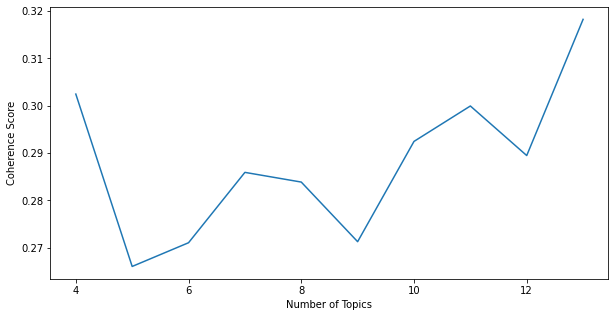

In [ ]:
custom_range = range(4,14)
#passes = 10
passes = 10

# Create Dictionary
tweets_dictionary = corpora.Dictionary(data_sample.tokenized_tweets)

# Create Corpus
texts = pisa_df.tokenized_tweets

# Term Document Frequency
tweets_corpus = [tweets_dictionary.doc2bow(text) for text in texts]

start_time = time.time()

# compute coherence
tweets_coherence = []
for nb_topics in custom_range:
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=passes,random_state=100)
    #cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass') #u_mass
    cohm = CoherenceModel(model=lda, texts=pisa_df.tokenized_tweets, dictionary=tweets_dictionary, coherence='c_v') 
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

stop_time = time.time()
print(f'Coherence computation for {passes} passes took: {(stop_time-start_time)/60:.2f}')

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(custom_range,tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fda67da1-eef2-4ddc-83c9-86a584779628' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>